In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm

from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import pearsonr as corr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

global_seed = 20230831

Using device: cuda


In [5]:
import sys
sys.path.append('/home/cool_klindt/PerceptualSimilarity')
import lpips

loss_fn_alex = lpips.LPIPS(net='alex').to(device) # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization
# ToDo: build batched LPIPS
def lpips_metric(a, b):
  img0 = torch.tensor(a, dtype=torch.float32, device=device)
  img1 = torch.tensor(b, dtype=torch.float32, device=device)
  with torch.no_grad():
      output = loss_fn_alex(img0, img1, normalize=True)
  return output.squeeze().detach().cpu().numpy()

a = torch.randn(43, 3, 32, 32).to(device)
b = torch.randn(27, 3, 32, 32).to(device)
lpips_metric(a, b).shape

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/cool_klindt/PerceptualSimilarity/lpips/weights/v0.1/alex.pth


/tmp/ipykernel_429288/2221526475.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img0 = torch.tensor(a, dtype=torch.float32, device=device)
/tmp/ipykernel_429288/2221526475.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1 = torch.tensor(b, dtype=torch.float32, device=device)


(43, 27)

In [6]:
def psychophyscis_lpips_batched(data_train, data_test, num_pair=10, seed=global_seed):
    num_unit = data_train.shape[0]
    assert not num_unit % 2
    num_train = data_train.shape[1]
    num_test = data_test.shape[1]
    target = np.zeros(num_test * 2)
    target[num_test:] = 1
    accuracies = np.zeros((num_unit, num_pair))
    for i in range(num_pair):
        np.random.seed(seed + i)
        ind_units = np.random.choice(num_unit, num_unit, replace=False)
        for j in range(num_unit // 2):
            ind_a = ind_units[j * 2]
            ind_b = ind_units[j * 2 + 1]
            data_train_pair = np.concatenate([data_train[ind_a], data_train[ind_b]], 0)
            data_test_pair = np.concatenate([data_test[ind_a], data_test[ind_b]], 0)
            similarities = lpips_metric(data_train_pair, data_test_pair)
            logits = np.stack([
                similarities[:num_train].min(0), similarities[num_train:].min(0)
            ], 1)
            accuracy = np.mean(logits.argmin(1) == target)
            accuracies[ind_a, i] = accuracies[ind_b, i] = accuracy
    return accuracies

In [2]:
from main_cifar10 import *

Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/cool_klindt/PerceptualSimilarity/lpips/weights/v0.1/alex.pth


In [3]:
log_dir = 'results/test4/'
with open(os.path.join(log_dir, 'results.pkl'), 'rb') as f:
        results = pickle.load(f)

In [4]:
results['layer1'].keys()

dict_keys(['output_shape', 'activations', 'activations_normed', 'kmeans_num_dic', 'kmeans_128', 'kmeans_128dist', 'kmeans_256', 'kmeans_256dist', 'kmeans_512', 'kmeans_512dist', 'data_train', 'data_test', 'data_train_kmeans_128', 'data_test_kmeans_128', 'data_train_kmeans_256', 'data_test_kmeans_256', 'data_train_kmeans_512', 'data_test_kmeans_512', 'probabilities', 'probabilities_kmeans_128', 'probabilities_kmeans_256', 'probabilities_kmeans_512', 'monosemanticity', 'monosemanticity_kmeans_128', 'monosemanticity_kmeans_256', 'monosemanticity_kmeans_512', 'kmeans_128_top', 'kmeans_128_topdist', 'data_train_kmeans_128_top', 'data_test_kmeans_128_top', 'monosemanticity_kmeans_128_top', 'kmeans_128_bottom', 'kmeans_128_bottomdist', 'data_train_kmeans_128_bottom', 'data_test_kmeans_128_bottom', 'monosemanticity_kmeans_128_bottom', 'kmeans_256_top', 'kmeans_256_topdist', 'data_train_kmeans_256_top', 'data_test_kmeans_256_top', 'monosemanticity_kmeans_256_top', 'kmeans_256_bottom', 'kmeans_2

Sparisity

In [5]:
results['layer1']['output_shape']

torch.Size([256, 16, 16])

In [6]:
kmeans_256_bottom = results['layer1']['kmeans_256_bottom'].cluster_centers_.copy()
kmeans_256_top = results['layer1']['kmeans_256_top'].cluster_centers_.copy()

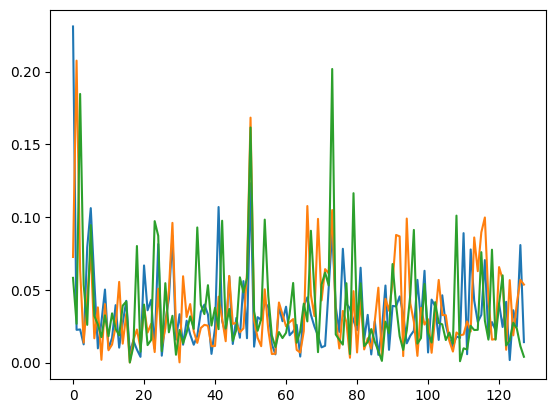

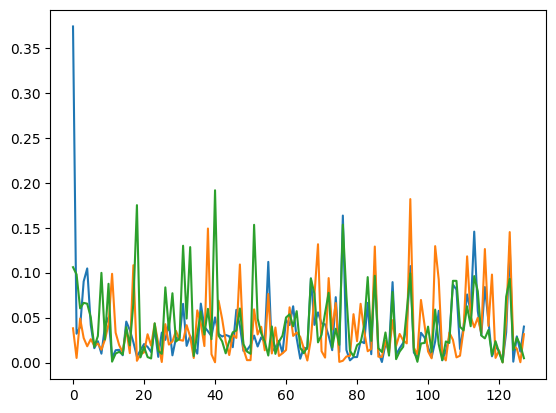

In [7]:
plt.plot(kmeans_256_bottom[:3].T)
plt.show()

plt.plot(kmeans_256_top[:3].T)
plt.show()

In [8]:
np.mean(abs(kmeans_256_bottom)), np.mean(abs(kmeans_256_top))

(0.038477696, 0.036972538)

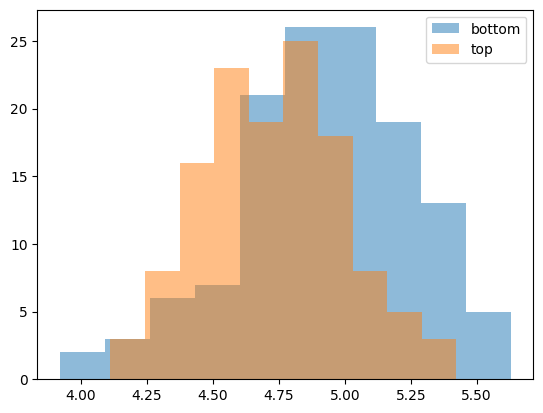

In [9]:
plt.hist(np.sum(abs(kmeans_256_bottom), 1), alpha=.5, label='bottom')
plt.hist(np.sum(abs(kmeans_256_top), 1), alpha=.5, label='top')
plt.legend()

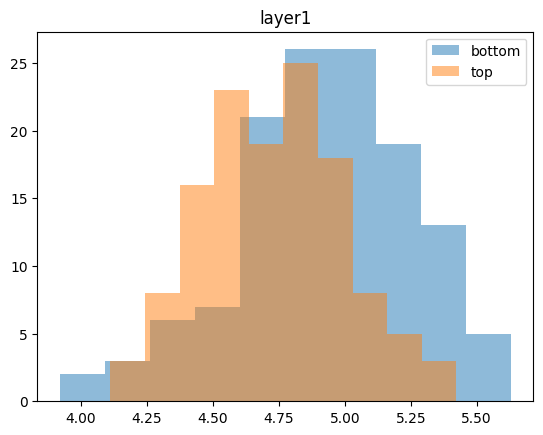

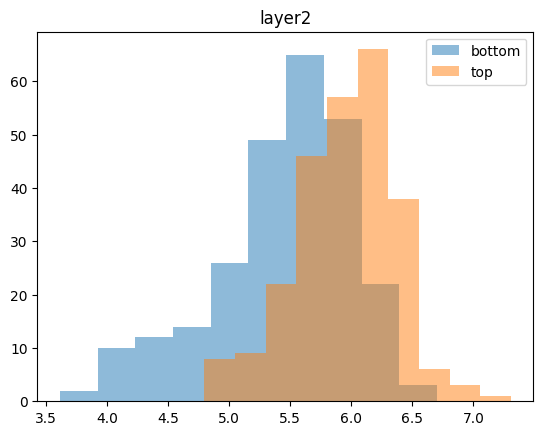

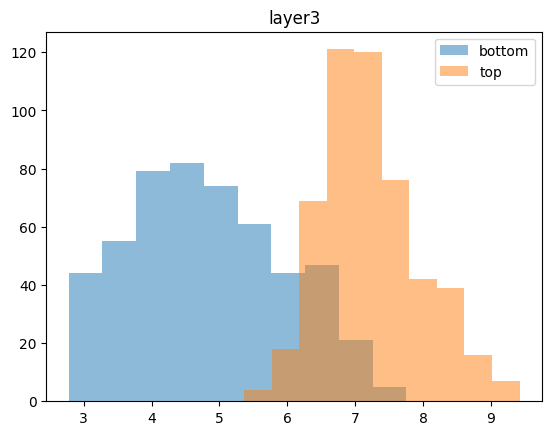

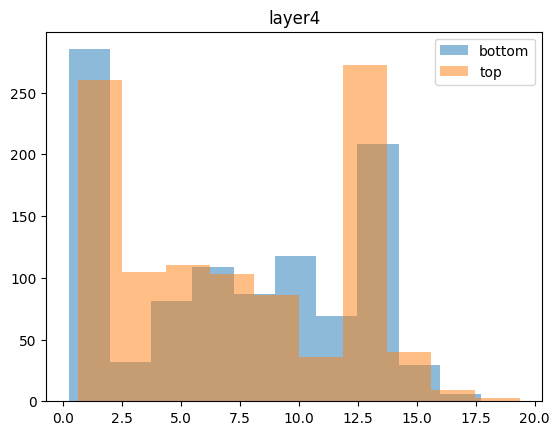

In [11]:
for key in results['keys']:
    num_unit = results[key]['output_shape'][0]
    kmeans_bottom = results[key]['kmeans_%s_bottom' % num_unit].cluster_centers_.copy()
    kmeans_top = results[key]['kmeans_%s_top' % num_unit].cluster_centers_.copy()
    plt.title(key)
    plt.hist(np.sum(abs(kmeans_bottom), 1), alpha=.5, label='bottom')
    plt.hist(np.sum(abs(kmeans_top), 1), alpha=.5, label='top')
    plt.legend()
    plt.show()

    """
    plt.title(key)
    tmp = abs(kmeans_bottom)
    tmp /= np.std(tmp, 1)
    tmp = np.max(tmp, 1)
    plt.hist(tmp, alpha=.5, label='bottom')
    tmp = abs(kmeans_top)
    tmp /= np.std(tmp, 1)
    tmp = np.max(tmp, 1)
    plt.hist(tmp, alpha=.5, label='top')
    plt.legend()
    plt.show()
    """

In [43]:
def pairwise_lpips(data_train, data_test, seed=global_seed):
    # new pair for every test image
    num_unit = data_train.shape[0]
    assert not num_unit % 2
    num_train = data_train.shape[1]
    num_test = data_test.shape[1]
    accuracies_mean = np.zeros((num_unit, num_test, 2))
    accuracies_min = np.zeros((num_unit, num_test, 2))
    for i in range(num_test):
        print('Test image', i, '/', num_test)
        np.random.seed(seed + i)
        ind_units = np.random.choice(num_unit, num_unit, replace=False)
        for j in range(num_unit // 2):
            ind_a = ind_units[j * 2]
            ind_b = ind_units[j * 2 + 1]
            similarities = np.zeros((2, 2, num_train))

            #for k in range(num_train):
            # use same train and test (one train ind only)
            k = i
            similarities[0, 0, k] = lpips_metric(data_test[ind_a, i], data_train[ind_a, k])
            similarities[0, 1, k] = lpips_metric(data_test[ind_a, i], data_train[ind_b, k])
            similarities[1, 0, k] = lpips_metric(data_test[ind_b, i], data_train[ind_a, k])
            similarities[1, 1, k] = lpips_metric(data_test[ind_b, i], data_train[ind_b, k])

            #for k in range(num_train):
            #    similarities[0, 0, k] = lpips_metric(data_test[ind_a, i], data_train[ind_a, k])
            #    similarities[0, 1, k] = lpips_metric(data_test[ind_a, i], data_train[ind_b, k])
            #    similarities[1, 0, k] = lpips_metric(data_test[ind_b, i], data_train[ind_a, k])
            #    similarities[1, 1, k] = lpips_metric(data_test[ind_b, i], data_train[ind_b, k])
            
            # average over training examples
            correct = 1.0 * (similarities.mean(2).argmin(1) == np.arange(2))
            accuracies_mean[ind_a, i] = correct
            accuracies_mean[ind_b, i] = correct
            # min over training examples
            correct = 1.0 * (similarities.min(2).argmin(1) == np.arange(2))
            accuracies_min[ind_a, i] = correct
            accuracies_min[ind_b, i] = correct
    return accuracies_mean, accuracies_min

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [44]:
key = 'layer1'
accuracies_mean, accuracies_min = pairwise_lpips(
        results[key]['data_train'][:, :], results[key]['data_test'][:, :]
    )
accuracies_mean.shape, accuracies_min.shape

Test image 0 / 5
Test image 1 / 5
Test image 2 / 5
Test image 3 / 5
Test image 4 / 5


((256, 5, 2), (256, 5, 2))

In [45]:
# 1 train per test
accuracies_mean.mean(), accuracies_min.mean()

(0.63203125, 0.5)

In [38]:
# 1 train
accuracies_mean.mean(), accuracies_min.mean()

(0.63828125, 0.63828125)

In [32]:
# 5 train
accuracies_mean.mean(), accuracies_min.mean()

(0.69921875, 0.71171875)

In [46]:
num_dic = 256
key = 'layer1'
key2 = 'kmeans' + '_%s' % num_dic
accuracies_mean, accuracies_min = pairwise_lpips(
        results[key]['data_train' + '_' + key2][:, :], 
        results[key]['data_test' + '_' + key2][:, :]
    )
accuracies_mean.shape, accuracies_min.shape

Test image 0 / 5
Test image 1 / 5
Test image 2 / 5
Test image 3 / 5
Test image 4 / 5


((256, 5, 2), (256, 5, 2))

In [47]:
# 1 train per test
accuracies_mean.mean(), accuracies_min.mean()

(0.65625, 0.5)

In [40]:
# 1 train
accuracies_mean.mean(), accuracies_min.mean()

(0.66640625, 0.66640625)

In [42]:
# 5 train
accuracies_mean.mean(), accuracies_min.mean()

(0.7140625, 0.72734375)

In [ ]:
# are 

In [2]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    x = img - np.min(img)
    x = x / np.max(x)
    plt.imshow(np.transpose(x, (1, 2, 0)))
    plt.axis('off')

# https://github.com/huyvnphan/PyTorch_CIFAR10

mean = [0.4914, 0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)])

batch_size = 64

#data_dir = '/content/drive/MyDrive/projects/data'
data_dir = '/home/cool_klindt/data'

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

images = next(iter(trainloader))[0]
images.shape

Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 3, 32, 32])

In [36]:
import sys
sys.path.append('/home/cool_klindt/Superposition/PyTorch_CIFAR10/')
from cifar10_models.resnet import resnet50

# Pretrained model
model = resnet50(pretrained=True)
model = model.to(device)
model.eval() # for evaluation

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
# Pick layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer1.register_forward_hook(get_activation('layer1'))
model.layer2.register_forward_hook(get_activation('layer2'))
model.layer3.register_forward_hook(get_activation('layer3'))
model.layer4.register_forward_hook(get_activation('layer4'))
output = model(images.to(device))
output_shape = activation['layer1'].shape[1:]
output_shape2 = activation['layer2'].shape[1:]
print('output_shape', output_shape, output_shape2)

output_shape torch.Size([256, 16, 16]) torch.Size([512, 8, 8])


In [38]:
for key in activation:
    print(key, activation[key].shape)

layer1 torch.Size([64, 256, 16, 16])
layer2 torch.Size([64, 512, 8, 8])
layer3 torch.Size([64, 1024, 4, 4])
layer4 torch.Size([64, 2048, 2, 2])


In [5]:
# decapitate network
model.layer2 = torch.nn.Identity()
model.layer3 = torch.nn.Identity()
model.layer4 = torch.nn.Identity()
model.avgpool = torch.nn.Identity()
model.fc = torch.nn.Identity()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Experiment

In [6]:
# Get activations
model = model.to(device)
def forward(x, ind_x=7, ind_y=7):
  return model(x.to(device)).reshape(-1, *output_shape)[:, :, ind_x, ind_y]

activations, inputs, labels = [], [], []
with torch.no_grad():
  for batch in trainloader:
    inputs.append(batch[0].detach().cpu().numpy().copy())
    labels.append(batch[1].detach().cpu().numpy().copy())
    #if not len(inputs) % 100:
    #  print(len(inputs))
    output = forward(batch[0])
    activations.append(output.detach().cpu().numpy().copy())
inputs = np.concatenate(inputs, 0)
labels = np.concatenate(labels, 0)
activations = np.concatenate(activations, 0)
activations.shape, inputs.shape, labels.shape

((50000, 256), (50000, 3, 32, 32), (50000,))

In [7]:
def plot_meis(activations, ind_units=None, num_show=10, seed=global_seed):
  if ind_units is None:
    np.random.seed(seed)
    ind_units = np.random.choice(activations.shape[1], num_show, replace=False)
  else:
    num_show = len(ind_units)
  plt.figure(figsize=(num_show * 1.1, num_show * 1.1))
  for i in range(num_show):
    ind_unit = ind_units[i]
    y = activations[:, ind_unit].copy()
    print('unit', ind_unit, 'mean', y.mean(), 'std', y.std())
    ind_sort = np.argsort(y)[::-1]
    for j in range(num_show):
      plt.subplot(num_show, num_show, j + 1 + i * num_show)
      imshow(inputs[ind_sort[j]])
      plt.title('%.4f' % y[ind_sort[j]])
  plt.tight_layout()
  plt.show()

unit 32 mean 0.010271989 std 0.013320903
unit 191 mean 0.016682545 std 0.017857864
unit 253 mean 0.020591287 std 0.026479766
unit 236 mean 0.011368148 std 0.01857169
unit 229 mean 0.014763173 std 0.01584535
unit 6 mean 0.013431207 std 0.009973975
unit 145 mean 0.01453266 std 0.01795079
unit 103 mean 0.024421621 std 0.025191959
unit 8 mean 0.012538296 std 0.027480325
unit 151 mean 0.023686865 std 0.019544022


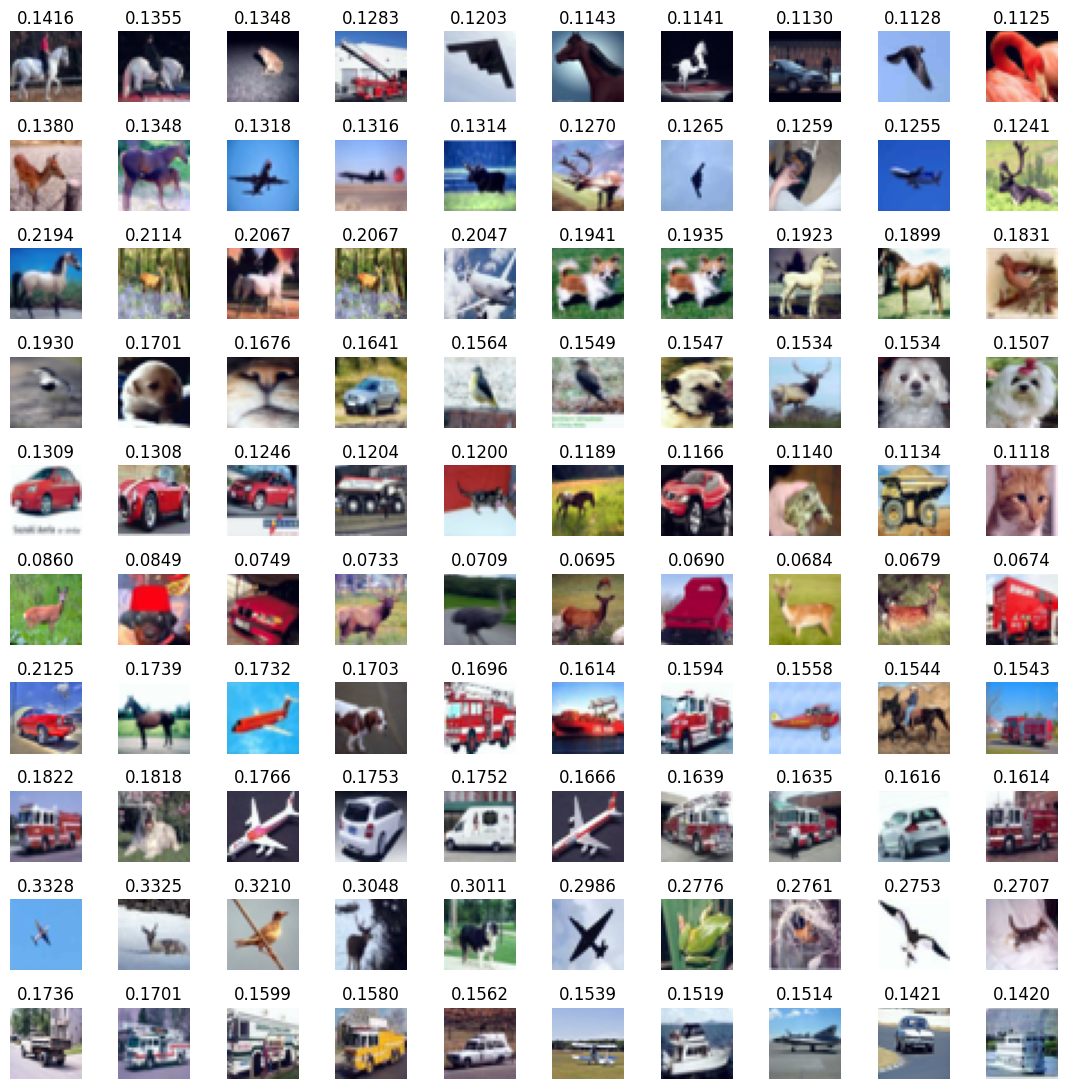

In [11]:
plot_meis(activations)

In [8]:
# Prepare activations as data
X = activations.copy()
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)
X = torch.tensor(X, dtype=torch.float32).to(device)

data = X.detach().cpu().numpy().copy()

length = np.sqrt((data**2).sum(axis=1))[:,None]
data_cos = data / length
print(X.shape, data.shape, data_cos.shape)

torch.Size([50000, 256]) (50000, 256) (50000, 256)


unit 32 mean -0.0036433707 std 0.059259392
unit 191 mean -0.001220801 std 0.063401595
unit 253 mean -0.0008423724 std 0.06387369
unit 236 mean -0.0008644812 std 0.06293572
unit 229 mean -0.00068934035 std 0.064136416
unit 6 mean 0.0020174957 std 0.06772074
unit 145 mean -0.0007010894 std 0.060522202
unit 103 mean -0.0017660788 std 0.06309484
unit 8 mean -0.0018455415 std 0.060583923
unit 151 mean 0.00033575608 std 0.06476343


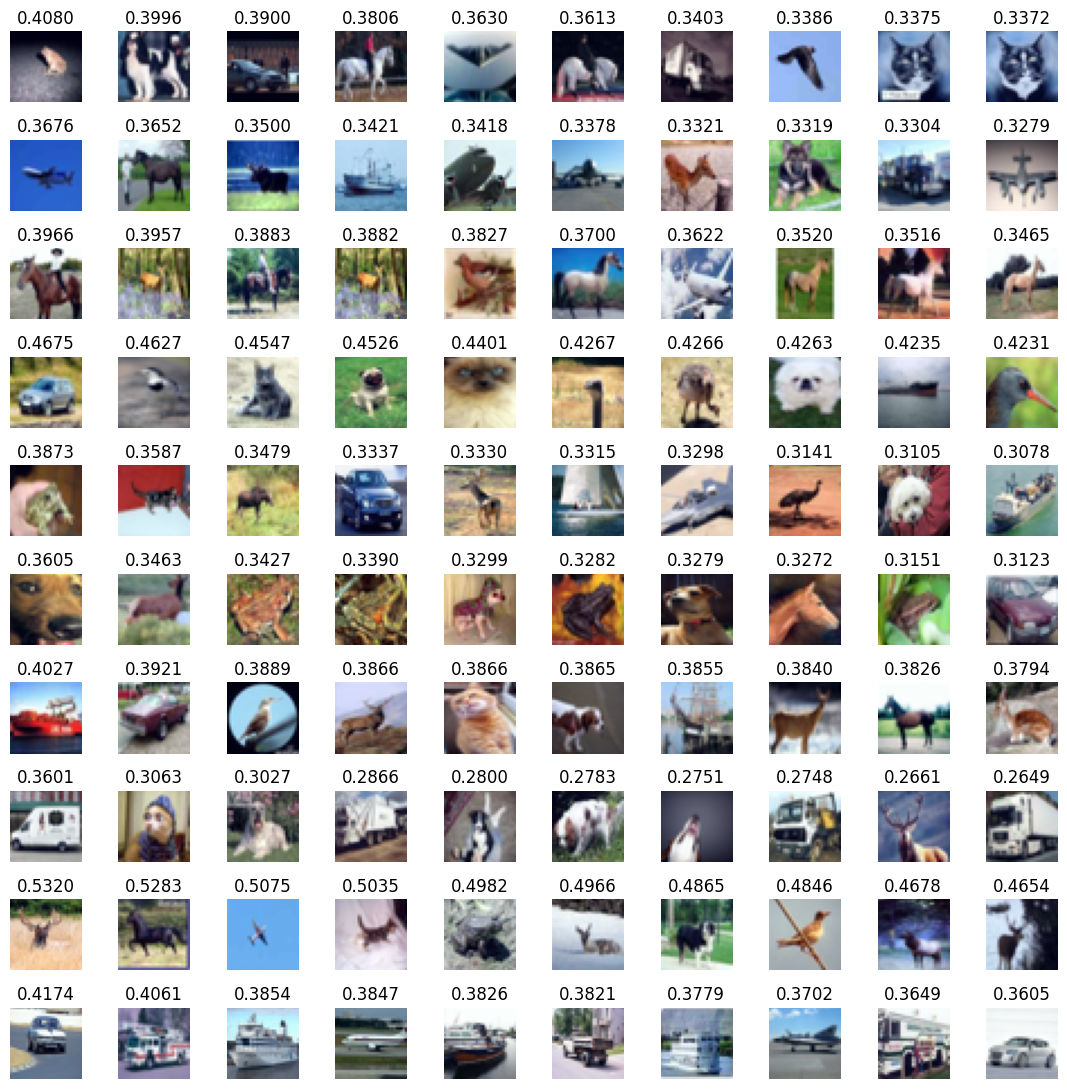

In [13]:
# Look at MEIs of normalized images
plot_meis(data_cos)

# LPIPS Psychophysics

In [9]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

# ToDo: build batched LPIPS

def lpips_metric(a, b):
  img0 = torch.tensor(a, dtype=torch.float32)
  img1 = torch.tensor(b, dtype=torch.float32)
  return loss_fn_alex(img0, img1, normalize=True).squeeze().item()

lpips_metric(inputs[0], inputs[1])

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


0.15395696461200714

In [10]:
def get_mei_data(data, num_train=5, num_test=5):
    "Get most activating images as train and test for lpips"
    num_unit = data.shape[1]
    data_train = np.zeros((num_unit, num_train, 3, 32, 32))
    data_test = np.zeros((num_unit, num_test, 3, 32, 32))
    for i in range(num_unit):
        y = data[:, i].copy()
        ind_sort = np.argsort(y)[::-1]
        data_train[i] = inputs[ind_sort[:num_train]].copy()
        data_test[i] = inputs[ind_sort[num_train:num_train + num_test]].copy()
    return data_train, data_test

data_train, data_test = get_mei_data(data)
data_train.shape, data_test.shape

((256, 5, 3, 32, 32), (256, 5, 3, 32, 32))

In [11]:
def get_monosemanticity(data_train):
    # Compute all pairwise distances and return average, lower is better
    num_unit = data_train.shape[0]
    num_train = data_train.shape[1]
    scores = np.zeros(num_unit)
    for i in range(num_unit):
        similarities = []
        for j in range(num_train):
            for k in range(j + 1, num_train):
                similarities.append(
                    lpips_metric(data_train[i, j], data_train[i, k])
                )
        scores[i] = np.mean(similarities)
    return scores

scores = get_monosemanticity(data_train)
print(scores)


[0.25256986 0.13632174 0.19189041 0.16980493 0.19128588 0.21917965
 0.21815075 0.20944797 0.30584549 0.23284012 0.17586781 0.20854479
 0.30362982 0.20816477 0.20225357 0.18319624 0.1718464  0.22777897
 0.2264597  0.23510914 0.22084841 0.1958482  0.18137891 0.2007052
 0.22742086 0.21470701 0.27531024 0.1034322  0.2941391  0.29378849
 0.2864045  0.21921726 0.21464157 0.29727215 0.19908162 0.16393718
 0.13554724 0.23970721 0.2545713  0.24125512 0.13682327 0.14173322
 0.23086444 0.1792356  0.17822193 0.19089359 0.16107497 0.23386769
 0.21211442 0.20448549 0.22518238 0.20430064 0.25768933 0.25607035
 0.26542147 0.200485   0.23105748 0.18041012 0.13262803 0.21244961
 0.11877048 0.27858059 0.25727533 0.10791827 0.17691218 0.14840313
 0.17770469 0.18084302 0.18988038 0.24782706 0.19867173 0.117385
 0.18753141 0.19388831 0.12200436 0.13653382 0.16791675 0.16043748
 0.25549412 0.21876258 0.2049014  0.17677179 0.06699085 0.13557705
 0.18672434 0.15765517 0.25147327 0.19782818 0.19079506 0.2288196

[0.06699085 0.0920837  0.0962229  0.09735966 0.1034322  0.10443268
 0.10791827 0.11057336 0.11155525 0.117385  ]
unit 82 mean 1.2422943e-06 std 1.000005
unit 193 mean -8.3068846e-07 std 0.9998938
unit 144 mean -5.071068e-07 std 1.0000013
unit 165 mean 2.493744e-06 std 1.0000211
unit 27 mean 2.9182434e-07 std 1.0000025
unit 216 mean 6.669617e-07 std 0.9997739
unit 63 mean -6.5411377e-06 std 1.0000021
unit 99 mean 6.412506e-08 std 0.99998766
unit 156 mean -2.4251938e-06 std 1.0000045
unit 71 mean -3.3954716e-06 std 1.0000021


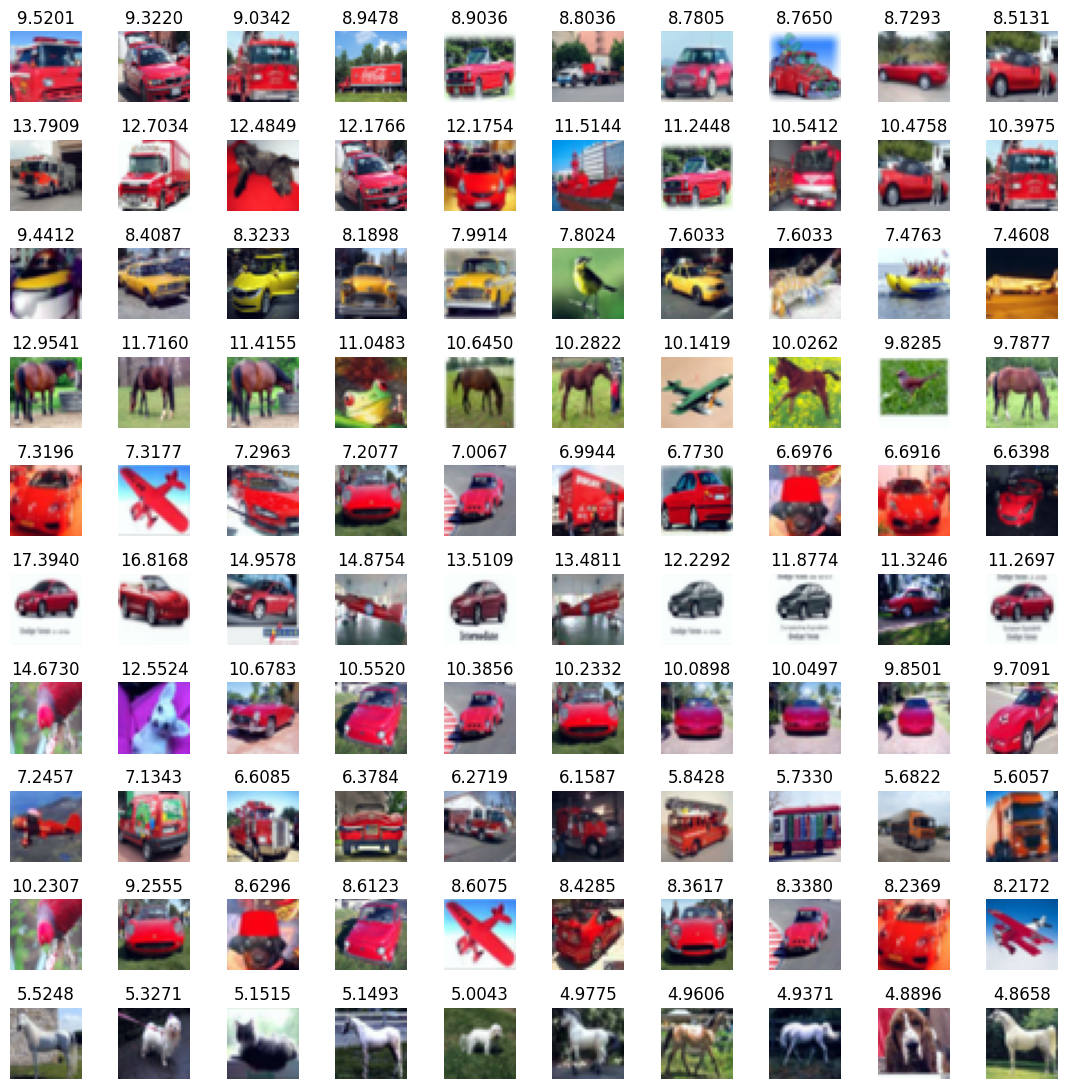

In [12]:
ind = np.argsort(scores)
print(scores[ind[:10]])
plot_meis(data, ind_units=ind[:10])

In [16]:
data_train_cos, data_test_cos = get_mei_data(-Y_cos)
scores_cos = get_monosemanticity(data_train_cos)

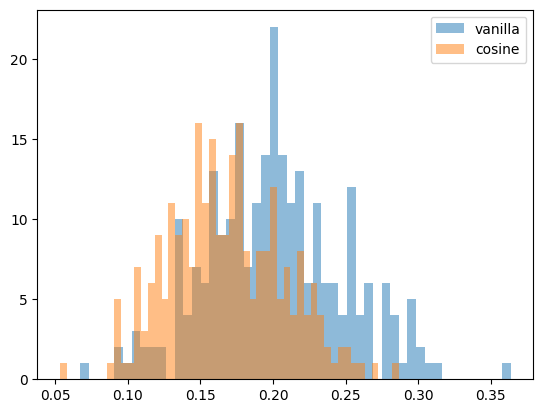

In [17]:
plt.hist(scores, 50, alpha=.5, label='vanilla')
plt.hist(scores_cos, 50, alpha=.5, label='cosine')
plt.legend()

{'bodies': [<matplotlib.collections.PolyCollection at 0x7eff7c7d03a0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7eff7c7d0250>,
 'cmins': <matplotlib.collections.LineCollection at 0x7eff7c7bf220>,
 'cbars': <matplotlib.collections.LineCollection at 0x7eff7c7bc040>}

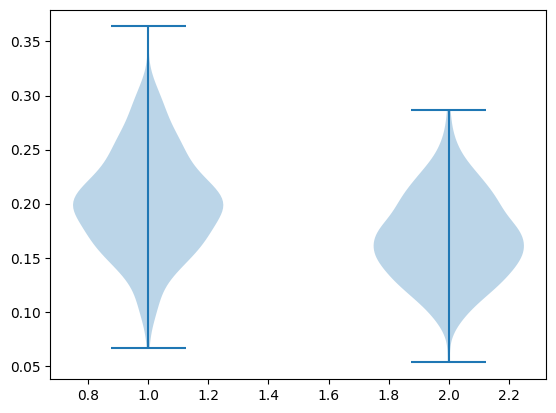

In [20]:
plt.violinplot([scores, scores_cos])

[0.05317718 0.08765989 0.09094744 0.09193907 0.09222414 0.09479224
 0.09504455 0.09939197 0.10235459 0.10468691]
unit 177 mean -1.2344623 std 0.09923966
unit 46 mean -1.194514 std 0.08111473
unit 71 mean -1.179183 std 0.09420235
unit 8 mean -1.174607 std 0.08630833
unit 110 mean -1.1880758 std 0.102126546
unit 106 mean -1.1980138 std 0.0935673
unit 61 mean -1.2300563 std 0.1263807
unit 53 mean -1.165364 std 0.07752677
unit 125 mean -1.1610522 std 0.07569259
unit 149 mean -1.1640447 std 0.09129791


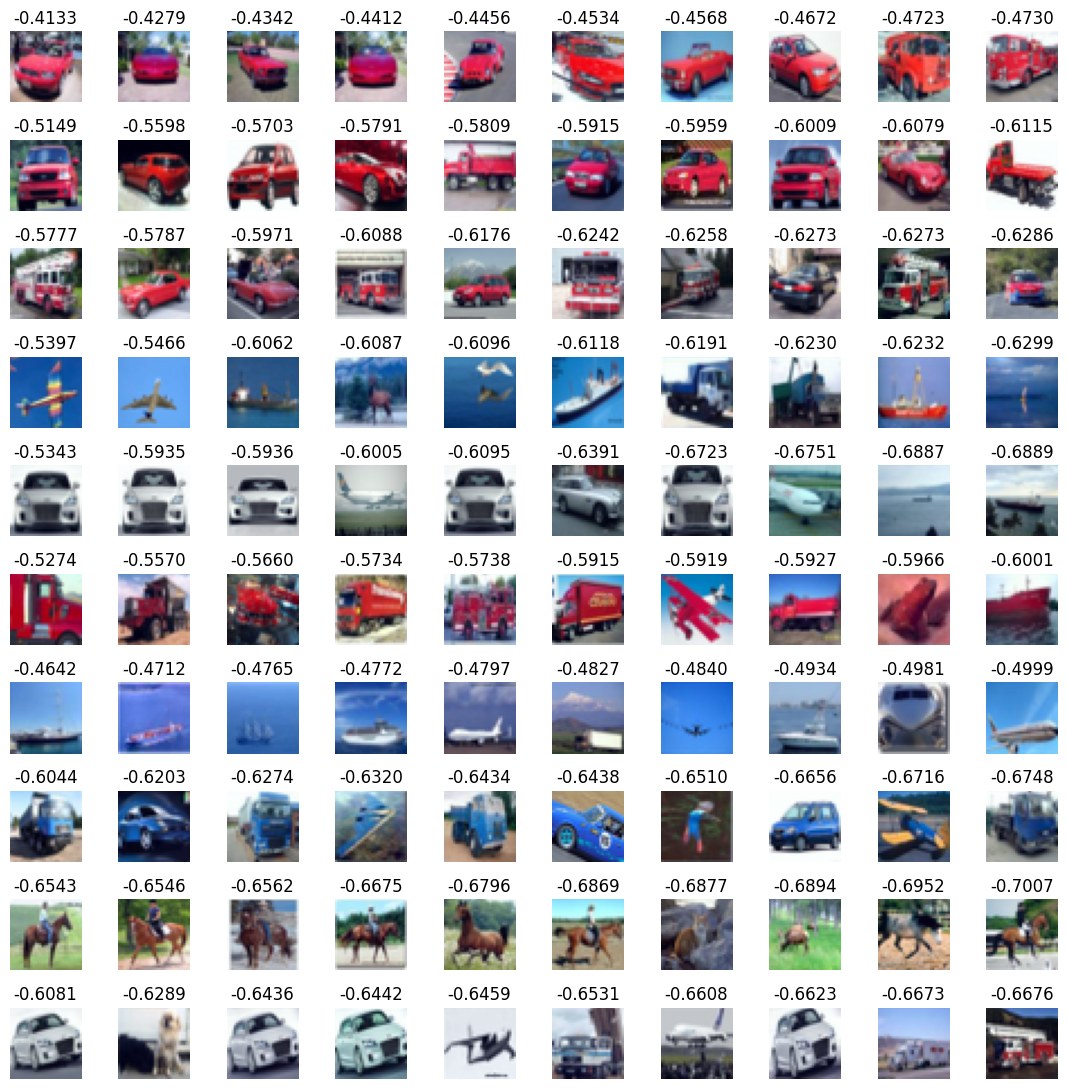

In [23]:
ind = np.argsort(scores_cos)
print(scores_cos[ind[:10]])
plot_meis(-Y_cos, ind_units=ind[:10])

In [28]:
def pairwise_lpips(data_train, data_test, seed=global_seed):
    num_unit = data_train.shape[0]
    assert not num_unit % 2
    num_train = data_train.shape[1]
    num_test = data_test.shape[1]
    np.random.seed(seed)
    ind_units = np.random.choice(num_unit, num_unit, replace=False)
    accuracies = np.zeros((num_unit // 2, num_test))
    for i in range(num_unit // 2):
        ind_a = ind_units[i * 2]
        ind_b = ind_units[i * 2 + 1]
        for j in range(num_test):
            similarities = np.zeros((2, 2, num_train))
            for k in range(num_train):
                similarities[0, 0, k] = lpips_metric(data_test[ind_a, j], data_train[ind_a, k])
                similarities[0, 1, k] = lpips_metric(data_test[ind_a, j], data_train[ind_b, k])
                similarities[1, 0, k] = lpips_metric(data_test[ind_b, j], data_train[ind_a, k])
                similarities[1, 1, k] = lpips_metric(data_test[ind_b, j], data_train[ind_b, k])
            accuracies[i, j] = np.mean(
                similarities.mean(2).argmin(1) == np.arange(2)
            )
        if not i % 10:
            print(i, 'acc', np.mean(accuracies[i]), accuracies[i])
    return accuracies

accuracies = pairwise_lpips(data_train, data_test[:, :1])

0 acc 1.0 [1.]
10 acc 0.5 [0.5]
20 acc 1.0 [1.]
30 acc 0.0 [0.]
40 acc 1.0 [1.]
50 acc 0.5 [0.5]
60 acc 1.0 [1.]
70 acc 0.5 [0.5]
80 acc 1.0 [1.]
90 acc 0.5 [0.5]
100 acc 1.0 [1.]
110 acc 0.5 [0.5]
120 acc 1.0 [1.]


In [29]:
accuracies.shape

(128, 1)

In [30]:
accuracies.mean()

0.703125

In [31]:
data_train_cos, data_test_cos = get_mei_data(-Y_cos)
accuracies_cos = pairwise_lpips(data_train_cos, data_test_cos[:, :1])
accuracies_cos.mean()

0 acc 1.0 [1.]
10 acc 1.0 [1.]
20 acc 1.0 [1.]
30 acc 1.0 [1.]
40 acc 0.5 [0.5]
50 acc 1.0 [1.]
60 acc 0.5 [0.5]
70 acc 1.0 [1.]
80 acc 1.0 [1.]
90 acc 0.5 [0.5]
100 acc 1.0 [1.]
110 acc 1.0 [1.]
120 acc 1.0 [1.]


0.7578125

In [ ]:
os

In [15]:
def lpips_eval(
    data,
    num_unit=10,
    num_train=5,
    num_test=1,
    seed=global_seed,
    plot=True
    ):
    np.random.seed(seed)
    ind_units = np.random.choice(data.shape[1], num_unit, replace=False)
    unit_train = np.zeros((len(ind_units), num_train, 3, 32, 32))
    unit_test = np.zeros((len(ind_units), num_test, 3, 32, 32))
    if plot:
      plt.figure(figsize=(num_train + num_test, num_unit))
    for i, ind_unit in enumerate(ind_units):
      y = data[:, ind_unit].copy()
      if plot:
        print('unit', ind_unit, 'mean', y.mean(), 'std', y.std())
      ind_sort = np.argsort(y)[::-1]
      for j in range(num_train):
        unit_train[i, j] = inputs[ind_sort[j]].copy()
        if plot:
          plt.subplot(num_unit, num_train + num_test, j + 1 + i * (num_train + num_test))
          imshow(unit_train[i, j])
          plt.title('train %s, %s' % (i, j))
      for j in range(num_test):
        unit_test[i, j] = inputs[ind_sort[j + num_train]].copy()
        if plot:
          plt.subplot(num_unit, num_train + num_test, j + 1 + num_train + i * (num_train + num_test))
          imshow(unit_test[i, j])
          plt.title('test %s, %s' % (i, j))
    if plot:
      plt.tight_layout()
      plt.show()

    comparisons = np.zeros((num_unit, num_unit, num_train, num_test))
    for i in range(num_unit):
      for j in range(num_unit):
        for k in range(num_train):
          for l in range(num_test):
            comparisons[i, j, k, l] = lpips_metric(
                unit_train[i, k], unit_test[j, l]
            )
    accuracy = []
    for l in range(num_test):
      accuracy.append(
          np.mean(np.mean(comparisons[:, :, :, l], axis=2).argmin(1) == np.arange(num_unit))
      )

    print('Accuracy', np.mean(accuracy))

unit 32 mean 9.914016e-07 std 1.0000024
unit 191 mean 3.6550903e-06 std 0.9999634
unit 253 mean 9.409332e-07 std 1.0000027
unit 236 mean -3.584282e-05 std 0.99999577
unit 229 mean -2.5987244e-06 std 1.0000037
unit 6 mean 4.0863656e-06 std 1.0000005
unit 145 mean 1.3322449e-06 std 1.0000561
unit 103 mean -7.2720336e-06 std 1.0000042
unit 8 mean 2.2628784e-07 std 1.0001873
unit 151 mean -4.124298e-06 std 1.0000185


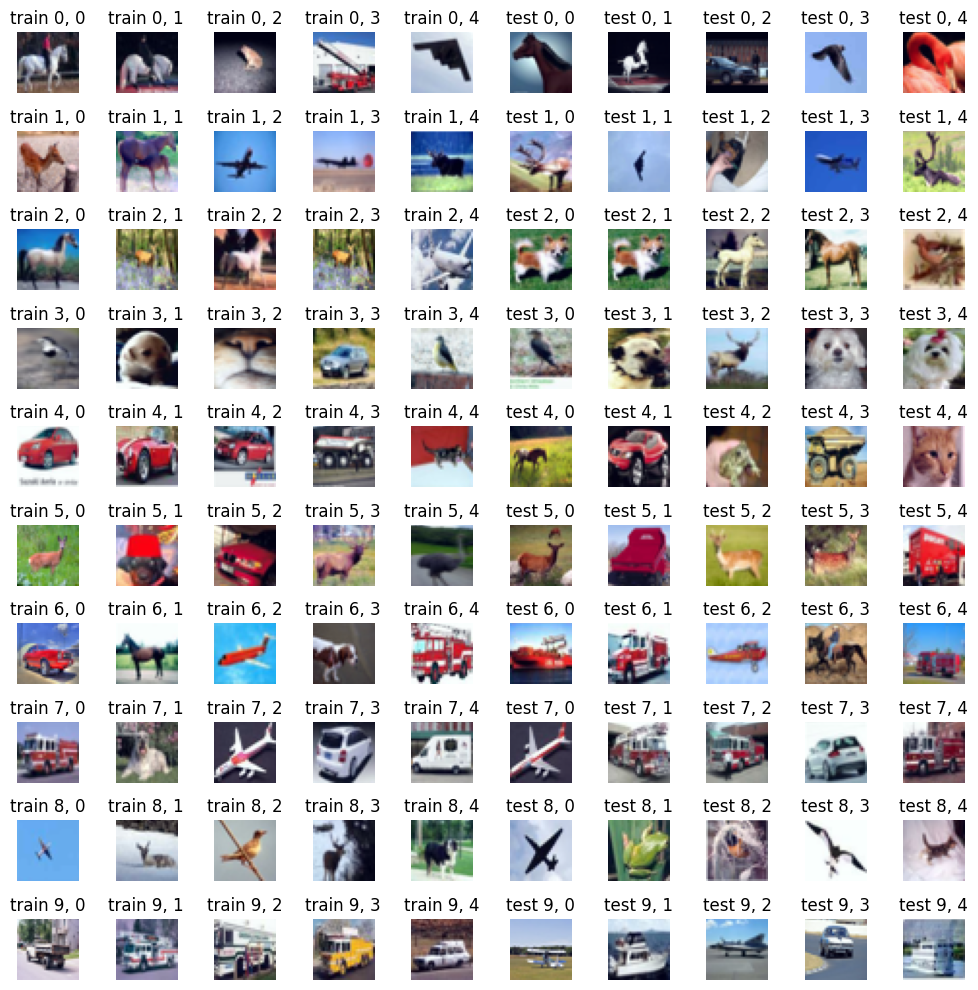

Accuracy 0.32


In [16]:
lpips_eval(data, num_unit=10, num_train=5, num_test=5, seed=global_seed, plot=True)

# K Means

In [13]:
num_dic = 256

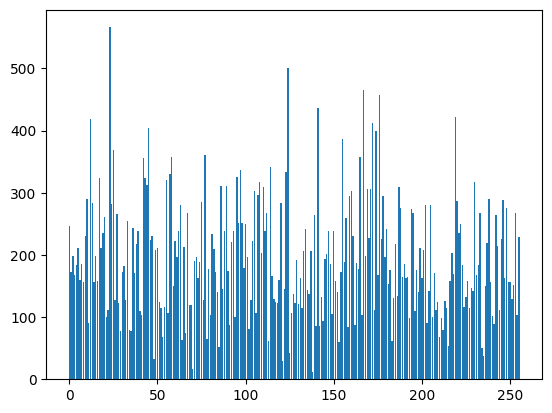

unit 32 mean -19.598906 std 2.7521365
unit 191 mean -19.740519 std 2.7615507
unit 253 mean -18.627481 std 3.3311975
unit 236 mean -19.426962 std 2.979548
unit 229 mean -19.361109 std 2.9246972
unit 6 mean -20.230732 std 2.7115
unit 145 mean -18.607845 std 3.0786877
unit 103 mean -20.001684 std 2.858928
unit 8 mean -18.587015 std 3.0058582
unit 151 mean -18.099228 std 3.21115


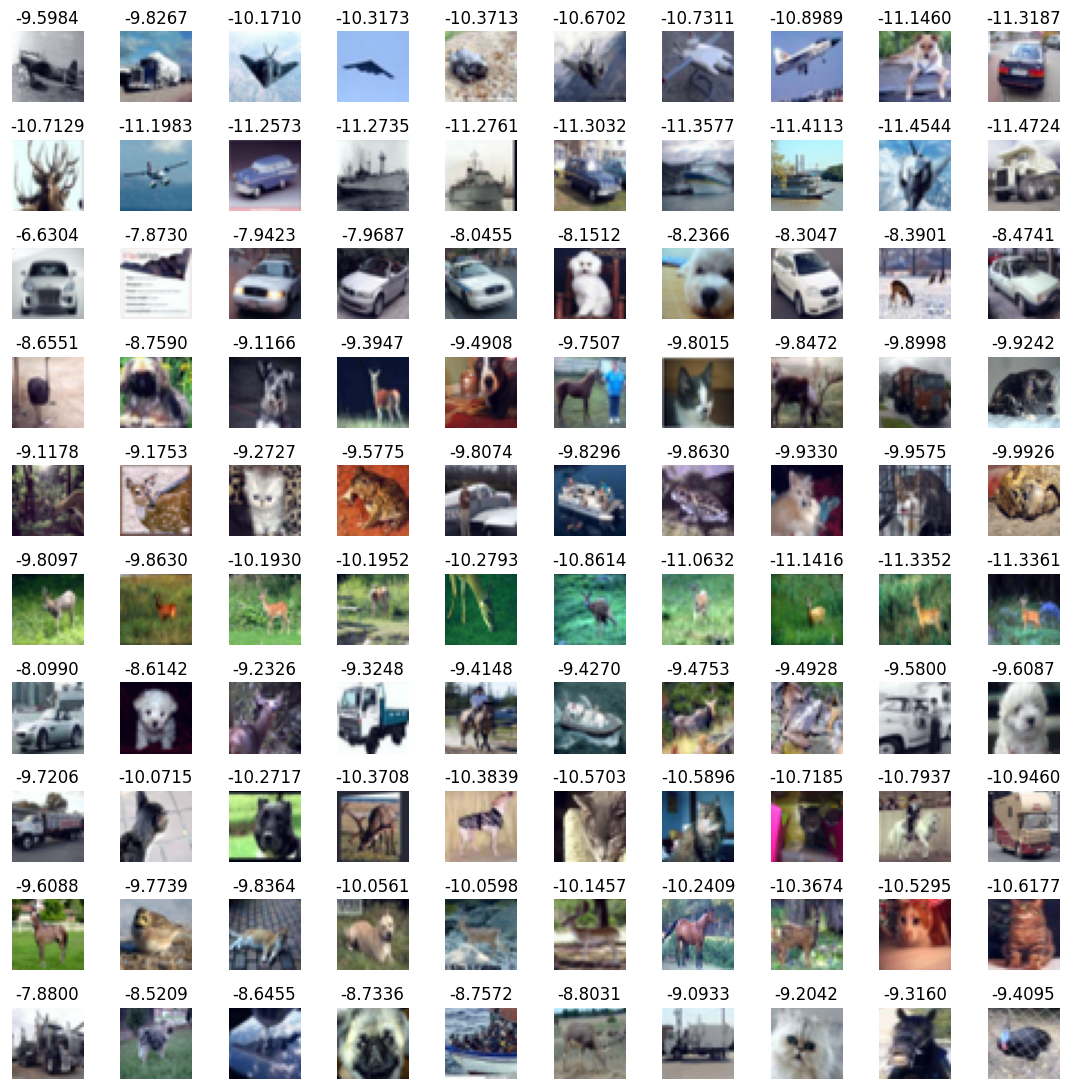

In [18]:
# Euclidean
kmeans = MiniBatchKMeans(
    n_clusters=num_dic,
    random_state=global_seed,
    #batch_size=6,
    #max_iter=10,
    #n_init="auto",
    verbose=False
).fit(data)

Y = kmeans.transform(data)

plt.bar(*np.unique(Y.argmin(1), return_counts=True))
plt.show()

plot_meis(-Y)

unit 32 mean -19.598906 std 2.7521365
unit 191 mean -19.740519 std 2.7615507
unit 253 mean -18.627481 std 3.3311975
unit 236 mean -19.426962 std 2.979548
unit 229 mean -19.361109 std 2.9246972
unit 6 mean -20.230732 std 2.7115
unit 145 mean -18.607845 std 3.0786877
unit 103 mean -20.001684 std 2.858928
unit 8 mean -18.587015 std 3.0058582
unit 151 mean -18.099228 std 3.21115


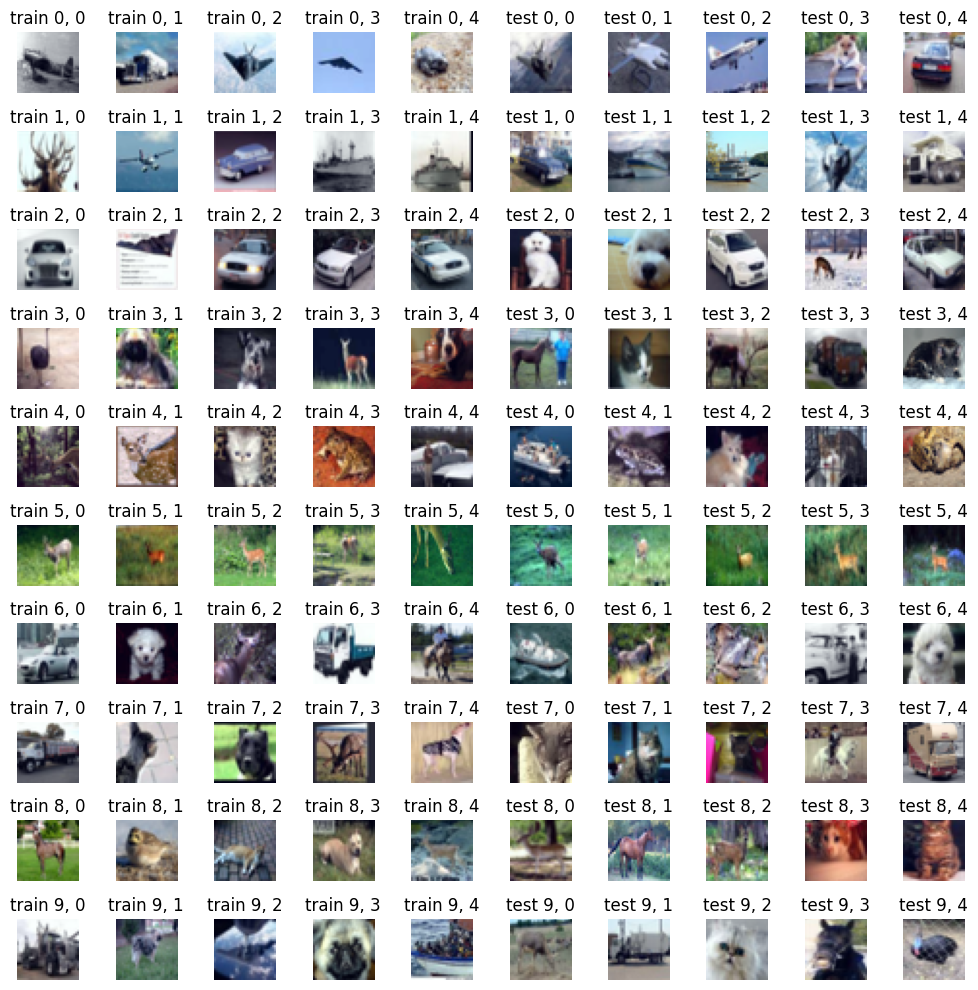

Accuracy 0.36


In [19]:
lpips_eval(-Y, num_unit=10, num_train=5, num_test=5, seed=global_seed, plot=True)

In [14]:
# Cosine kMeans
kmeans_cos = MiniBatchKMeans(
    n_clusters=num_dic,
    random_state=global_seed,
    #batch_size=6,
    #max_iter=10,
    #n_init="auto",
    verbose=False
).fit(data_cos)

Y_cos = kmeans_cos.transform(data_cos)

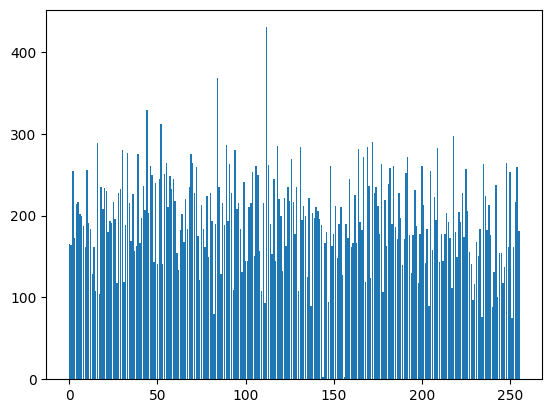

unit 32 mean -1.1560129 std 0.09338601
unit 191 mean -1.1956726 std 0.09021554
unit 253 mean -1.227831 std 0.12515804
unit 236 mean -1.1668164 std 0.08768368
unit 229 mean -1.1772628 std 0.09816237
unit 6 mean -1.1429322 std 0.08613817
unit 145 mean -1.1612773 std 0.10088316
unit 103 mean -1.180369 std 0.0815388
unit 8 mean -1.1696512 std 0.093763046
unit 151 mean -1.1399077 std 0.091721125


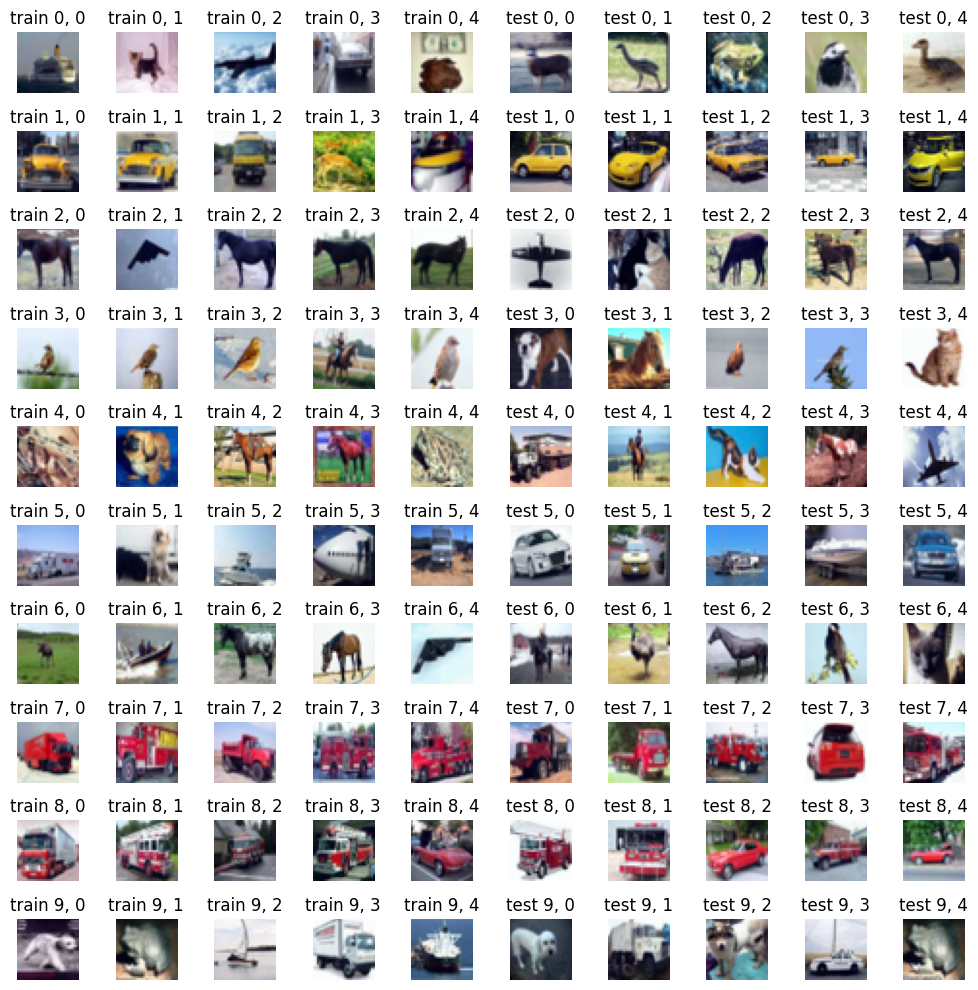

Accuracy 0.45999999999999996


In [20]:
# Cosine kMeans
kmeans_cos = MiniBatchKMeans(
    n_clusters=num_dic,
    random_state=global_seed,
    #batch_size=6,
    #max_iter=10,
    #n_init="auto",
    verbose=False
).fit(data_cos)

Y_cos = kmeans_cos.transform(data_cos)
plt.bar(*np.unique(Y_cos.argmin(1), return_counts=True))
plt.show()

lpips_eval(-Y_cos, num_unit=10, num_train=5, num_test=5, seed=global_seed, plot=True)

# T-SNE Embeddings

In [ ]:
kmeans.cluster_centers_.shape

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', random_state=global_seed,
                  init='random', perplexity=3).fit_transform(data.T)
X_embedded.shape

In [ ]:
data.shape, labels.shape

In [ ]:
most_activating_class = []
for i in range(data.shape[1]):
  ind = data[:, i].argsort()[::-1]
  most_activating_class.append(
      mode(labels[ind[:10]])[0][0]
  )

In [ ]:
plt.scatter(*X_embedded.T, c=most_activating_class)
plt.colorbar()

In [ ]:
K_embedded = TSNE(n_components=2, learning_rate='auto', random_state=global_seed,
                  init='random', perplexity=3).fit_transform(kmeans.cluster_centers_)
K_embedded.shape

In [ ]:
most_activating_class_K = []
for i in range(Y.shape[1]):
  ind = Y[:, i].argsort()
  most_activating_class_K.append(
      mode(labels[ind[:10]])[0][0]
  )

In [ ]:
plt.scatter(*K_embedded.T, c=most_activating_class_K)
plt.colorbar()

In [ ]:
coefficients = - Y_cos

In [ ]:
np.random.seed(global_seed)
ind_units = np.random.choice(num_dic, 10, replace=False)
plt.figure(figsize=(12, 12))
for i in range(10):
  ind_unit = ind_units[i]
  y = coefficients[:, ind_unit].copy()
  print('unit', ind_unit, 'mean', y.mean(), 'std', y.std())
  ind_sort = np.argsort(y)[::-1]
  for j in range(num_show):
    plt.subplot(10, num_show, j + 1 + i * num_show)
    imshow(inputs[ind_sort[j]])
    plt.title(y[ind_sort[j]])
plt.tight_layout()
plt.show()

In [ ]:
# normalize centers
len_ = np.sqrt(np.square(kmeans_cos.cluster_centers_).sum(axis=1)[:,None])
centers = kmeans_cos.cluster_centers_.copy() / len_
kmeans_cos.cluster_centers_ = centers

Y_cos = kmeans_cos.transform(data_cos)
plt.bar(*np.unique(Y_cos.argmin(1), return_counts=True))
plt.show()

coefficients = - Y_cos

np.random.seed(global_seed)
ind_units = np.random.choice(num_dic, 10, replace=False)
plt.figure(figsize=(12, 12))
for i in range(10):
  ind_unit = ind_units[i]
  y = coefficients[:, ind_unit].copy()
  print('unit', ind_unit, 'mean', y.mean(), 'std', y.std())
  ind_sort = np.argsort(y)[::-1]
  for j in range(num_show):
    plt.subplot(10, num_show, j + 1 + i * num_show)
    imshow(inputs[ind_sort[j]])
    plt.title(y[ind_sort[j]])
plt.tight_layout()
plt.show()

In [ ]:
len_ = np.sqrt(np.square(kmeans_cos.cluster_centers_).sum(axis=1)[:,None])
centers = kmeans_cos.cluster_centers_.copy() / len_

cos_embedded = TSNE(n_components=2, learning_rate='auto', random_state=global_seed,
                  init='random', perplexity=3, metric='cosine').fit_transform(centers)
most_activating_class_cos = []
for i in range(Y_cos.shape[1]):
  ind = Y_cos[:, i].argsort()
  most_activating_class_cos.append(
      mode(labels[ind[:10]])[0][0]
  )
plt.scatter(*cos_embedded.T, c=most_activating_class_cos)
plt.colorbar()

In [ ]:
# Cosine Unit Centers
kmeans_cos.cluster_centers_ = np.eye(num_dic)
Y_cos = kmeans_cos.transform(data_cos)
plt.bar(*np.unique(Y_cos.argmin(1), return_counts=True))
plt.show()

coefficients = - Y_cos

np.random.seed(global_seed)
ind_units = np.random.choice(num_dic, 10, replace=False)
plt.figure(figsize=(12, 12))
for i in range(10):
  ind_unit = ind_units[i]
  y = coefficients[:, ind_unit].copy()
  print('unit', ind_unit, 'mean', y.mean(), 'std', y.std())
  ind_sort = np.argsort(y)[::-1]
  for j in range(num_show):
    plt.subplot(10, num_show, j + 1 + i * num_show)
    imshow(inputs[ind_sort[j]])
    plt.title(np.round(y[ind_sort[j]], 4))
plt.tight_layout()
plt.show()